In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import pandas as pd
import transformers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from llm_style.formality_dataset import FormalityDataset, PavlickFormalityDataset
from llm_style.domain_dataset import DomainDataset, DomainType


In [2]:
dataset = DomainDataset(mode="int")

In [3]:
pipeline = transformers.pipeline(
    "text-generation",
    model="microsoft/phi-4",
    model_kwargs={"torch_dtype": "auto"},
    device_map="auto",
)


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Device set to use mps


In [4]:
# Get device for computation
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

# Extract texts and labels from the dataset
texts = []
labels = []
for i in range(0, 250):
    # if i >= len(dataset):
    #     break
    sample = dataset[i]
    if "text" not in sample or "label" not in sample:
        print(f"Skipping index {i} due to missing fields.")
        continue
    texts.append(sample["text"])
    labels.append(sample["label"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)


# Define a function to extract features from text
def extract_features(model, tokenizer, texts, layer_idx):
    # Move model to the correct device if not already there
    # model_device = next(model.parameters()).device
    # if model_device != device:
    #     model = model.to(device)

    features = []
    batch_size = 16  # Adjust based on your GPU/memory

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        # Tokenize the texts
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512,
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get model outputs with no gradient computation
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Extract hidden states from the specified layer
        # For phi-4 model, access the proper hidden states format
        if hasattr(outputs, "hidden_states"):
            hidden_states = outputs.hidden_states[layer_idx]
        else:
            # If hidden_states is a tuple, access it directly
            hidden_states = outputs[2][layer_idx]
        hidden_states = hidden_states.to(torch.float32)

        # Average across the token dimension to get a fixed-size representation
        batch_features = hidden_states.mean(dim=1)
        batch_features_cpu = batch_features.cpu().numpy()
        features.append(batch_features_cpu)

    return np.vstack(features)



Using device: mps


In [5]:
class LatentBottleneck(nn.Module):
    def __init__(self, dim_model: int, dim_latent: int):
        super().__init__()
        self.down = nn.Linear(dim_model, dim_latent)
        self.up = nn.Linear(dim_latent, dim_model)

    def forward(self, x):
        return self.up(self.down(x))

    def forward_latent(self, x):
        return self.down(x)

class LatentClassifier(nn.Module):
    def __init__(self, bottleneck: LatentBottleneck, num_classes: int):
        super().__init__()
        self.bottleneck = bottleneck
        self.classifier = nn.Linear(bottleneck.down.out_features, num_classes)

    def forward(self, x):
        latent = self.bottleneck.forward_latent(x)
        return self.classifier(latent)

class ResidualBottleneckWrapper(nn.Module):
    def __init__(self, layer: nn.Module, dim_model: int, dim_latent: int):
        super().__init__()
        self.layer = layer
        self.bottleneck = LatentBottleneck(dim_model, dim_latent)

    def forward(self, x, *args, **kwargs):
        bottleneck_out = self.bottleneck(x)
        x_modified = x + bottleneck_out
        return self.layer(x_modified, *args, **kwargs)

# Example: bottleneck from original 5120
bottleneck = LatentBottleneck(dim_model=5120, dim_latent=32)

In [6]:
# Freeze all layers except the bottleneck
for param in pipeline.model.parameters():
    param.requires_grad = False
for param in bottleneck.parameters():
    param.requires_grad = True
# Insert the bottleneck into the model

# Wrap layer 21 in a residual bottleneck
original_layer = pipeline.model.model.layers[21]
dim_model = 5120
dim_latent = 6
wrapped_layer = ResidualBottleneckWrapper(original_layer, dim_model, dim_latent)
wrapped_layer = wrapped_layer.to(device)

# Replace in-place
pipeline.model.model.layers[21] = wrapped_layer

In [7]:
# Print all the layers and the count of their params:
def print_layers(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name}, Params: {param.numel()}")
print_layers(pipeline.model)

Layer: model.layers.21.bottleneck.down.weight, Params: 30720
Layer: model.layers.21.bottleneck.down.bias, Params: 6
Layer: model.layers.21.bottleneck.up.weight, Params: 30720
Layer: model.layers.21.bottleneck.up.bias, Params: 5120


In [8]:
# Now we'll train the bottleneck to one-hot the label
def train_latent_classifier(
    model: nn.Module,
    llm: nn.Module,
    tokenizer,
    X_train,
    y_train,
    layer_idx=21,
    epochs=5,
    batch_size=16,
):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1 * 10**(-3.5))
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            batch_texts = X_train[i : i + batch_size]
            batch_labels = y_train[i : i + batch_size]

            # Tokenize
            inputs = tokenizer(
                batch_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512,
            ).to(device)

            # Forward through frozen LLM to get hidden states
            with torch.no_grad():
                outputs = llm(**inputs, output_hidden_states=True)
                hidden_states = outputs.hidden_states[layer_idx]
                x = hidden_states.mean(dim=1).to(torch.float32).to(device)

            # Forward through latent classifier
            labels_tensor = torch.tensor(batch_labels, device=device)
            preds = model(x)
            loss = criterion(preds, labels_tensor)

            # Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f"Epoch {epoch+1}, Batch {i//batch_size+1}, Loss: {loss.item():.4f}")
        print(f"Epoch {epoch+1} completed.")

In [9]:
# Train the bottleneck
latent_classifier = LatentClassifier(bottleneck, num_classes=len(set(y_train))).to(device)
train_latent_classifier(
    latent_classifier,
    pipeline.model,
    pipeline.tokenizer,
    X_train,
    y_train,
    layer_idx=21,
    batch_size=32,
)

Epoch 1, Batch 1, Loss: 1.8988
Epoch 1, Batch 2, Loss: 1.1740
Epoch 1, Batch 3, Loss: 1.1027
Epoch 1, Batch 4, Loss: 1.0735
Epoch 1, Batch 5, Loss: 1.3455
Epoch 1, Batch 6, Loss: 1.5443
Epoch 1, Batch 7, Loss: 0.7666
Epoch 1 completed.
Epoch 2, Batch 1, Loss: 1.1061
Epoch 2, Batch 2, Loss: 0.9326
Epoch 2, Batch 3, Loss: 1.1480
Epoch 2, Batch 4, Loss: 0.7574
Epoch 2, Batch 5, Loss: 1.0023
Epoch 2, Batch 6, Loss: 1.0621
Epoch 2, Batch 7, Loss: 0.6338
Epoch 2 completed.
Epoch 3, Batch 1, Loss: 0.7710
Epoch 3, Batch 2, Loss: 0.6033
Epoch 3, Batch 3, Loss: 0.7157
Epoch 3, Batch 4, Loss: 0.5399
Epoch 3, Batch 5, Loss: 0.6200
Epoch 3, Batch 6, Loss: 0.7059
Epoch 3, Batch 7, Loss: 0.3129
Epoch 3 completed.
Epoch 4, Batch 1, Loss: 0.5035
Epoch 4, Batch 2, Loss: 0.5682
Epoch 4, Batch 3, Loss: 0.7880
Epoch 4, Batch 4, Loss: 0.4948
Epoch 4, Batch 5, Loss: 0.6291
Epoch 4, Batch 6, Loss: 0.5765
Epoch 4, Batch 7, Loss: 0.1516
Epoch 4 completed.
Epoch 5, Batch 1, Loss: 0.3947
Epoch 5, Batch 2, Loss: 0

In [21]:
def predict_domain(text: str, llm, tokenizer, classifier, layer_idx=21):
    classifier.eval()

    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512,
    ).to(device)

    with torch.no_grad():
        outputs = llm(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states[layer_idx]
        x = hidden_states.mean(dim=1).to(torch.float32).to(device)

        logits = classifier(x)
        predicted_class = logits.argmax(dim=1).item()

    return DomainType.from_int(predicted_class), logits

In [22]:
text = "I'd try unplugging your modem first to see if that's the problem."
pred, _ = predict_domain(text, pipeline.model, pipeline.tokenizer, latent_classifier, layer_idx=21)
print(f"Predicted domain class: {pred}")

Predicted domain class: blog


In [23]:
text = "When I first set out on this vacation, I was worried my shoes wouldn't last."
pred, _ = predict_domain(text, pipeline.model, pipeline.tokenizer, latent_classifier, layer_idx=21)
print(f"Predicted domain class: {pred}")

Predicted domain class: blog


In [24]:
text = "You need to send me the report by the end of the day."
pred, _ = predict_domain(text, pipeline.model, pipeline.tokenizer, latent_classifier, layer_idx=21)
print(f"Predicted domain class: {pred}")

Predicted domain class: email


In [25]:
text = "In breaking news, a major earthquake has struck the city, causing widespread damage and panic."
pred, _ = predict_domain(text, pipeline.model, pipeline.tokenizer, latent_classifier, layer_idx=21)
print(f"Predicted domain class: {pred}")

Predicted domain class: news


In [37]:
# Confusion matrix:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
# Evaluate the model on the test set
y_pred = []
for text in X_test:
    pred, _ = predict_domain(text, pipeline.model, pipeline.tokenizer, latent_classifier, layer_idx=21)
    y_pred.append(pred)


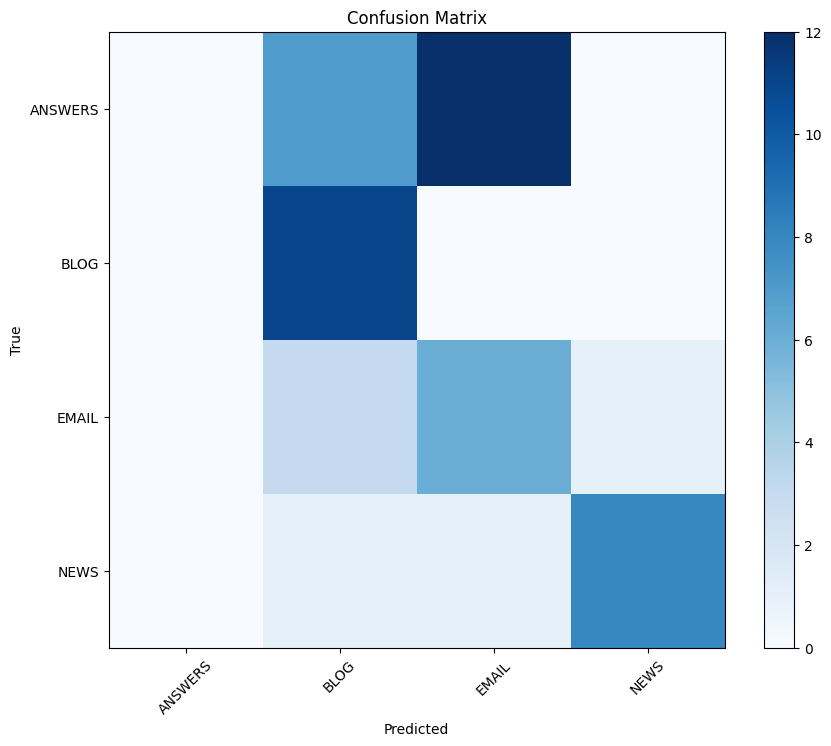

Accuracy: 0.0000


In [39]:
# Plot confusion matrix
plot_confusion_matrix(y_test, [DomainType.as_int(y) for y in y_pred], [
"ANSWERS",
"BLOG",
"EMAIL",
"NEWS",
])
# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")